<a href="https://colab.research.google.com/github/evinracher/3010090-ontological-engineering/blob/main/week2/part3/01_Creacion_Grafo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌐 Taller Introductorio de LangGraph (Google Colab)
### Usando LangChain 1.1 + LangGraph 1.0 + Gemini
Este cuaderno introduce los conceptos básicos de LangGraph: estado, nodos, definición del grafo, ejecución, visualización y uso.

El dominio de aplicación es el contar un chiste.

## Instalación de librerías

In [1]:
# Instalación de librerías
%pip install -U langgraph langchain_google_genai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.1/158.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 3.3 MB/s eta 0:00:00
  Attempting uninstall: langgraph
    Found existing installation: langgraph 1.0.7
    Uninstalling langgraph-1.0.7:
      Successfully uninstalled langgraph-1.0.7


## 🔑 Configurar API Key de Gemini

In [2]:
from google.colab import userdata
import os

api_key = userdata.get('GOOGLE_API_KEY')
os.environ['GOOGLE_API_KEY'] = api_key
print('API Key cargada:', 'Sí' if api_key else 'No')

API Key cargada: Sí


## 📌 Importar clases necesarias

In [3]:
from typing import Sequence
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END

## 🤖 Crear el modelo Gemini para el grafo

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

MODEL_ID = os.getenv("GEMINI_MODEL", "models/gemini-2.5-flash-lite")

llm = ChatGoogleGenerativeAI(model=MODEL_ID, temperature=0.2)
print("✅ LLM listo:", MODEL_ID)


✅ LLM listo: models/gemini-2.5-flash-lite


## 🧩 Definir el Estado
El estado en LangGraph es un diccionario tipado (TypedDict) que contiene los datos que fluyen entre nodos.

In [5]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


In [6]:
# Estado del grafo - Define la estructura de datos que se pasa entre nodos
class Estado(TypedDict):
    tema: str              # Tema sobre el que se creará el chiste
    chiste: str            # Chiste inicial generado
    chiste_mejorado: str   # Chiste después de la primera mejora
    chiste_final: str      # Chiste pulido final

## 🔧 Definir un nodo
Cada nodo es una función que recibe el estado y devuelve un nuevo estado.

En este caso hay 4 funciones, donde cada función representa un paso en el proceso (Nodo).

In [7]:
def generar_chiste(estado: Estado):
    """Primera llamada al LLM para generar el chiste inicial"""
    resp = llm.invoke(f"Escribe un chiste corto sobre {estado['tema']}")
    return {"chiste": resp.content}

def verificar_remate(estado: Estado):
    """Función de control para verificar si el chiste tiene un buen remate"""
    # Check if the joke ends with a common punchline punctuation
    if estado["chiste"].strip().endswith((".", "!", "?")):
        return "Aprobado"
    return "Rechazado"

def mejorar_chiste(estado: Estado):
    """Segunda llamada al LLM para mejorar el chiste"""
    resp = llm.invoke(
        f"Haz este chiste más gracioso añadiendo juegos de palabras: {estado['chiste']}"
    )
    return {"chiste_mejorado": resp.content}

def pulir_chiste(estado: Estado):
    """Tercera llamada al LLM para el pulido final"""
    resp = llm.invoke(
        f"Añade un giro sorprendente a este chiste: {estado['chiste_mejorado']}"
    )
    return {"chiste_final": resp.content}

## 🏗️ Construcción del grafo (flujo de trabajo)

In [8]:
# Construir el flujo de trabajo
flujo_trabajo = StateGraph(Estado)

# Agregar nodos al grafo
flujo_trabajo.add_node("generar_chiste", generar_chiste)
flujo_trabajo.add_node("mejorar_chiste", mejorar_chiste)
flujo_trabajo.add_node("pulir_chiste", pulir_chiste)

# Agregar conexiones entre nodos
# Conexión desde el inicio al primer nodo
flujo_trabajo.add_edge(START, "generar_chiste")

# Conexión condicional - decide el camino según la calidad del chiste
flujo_trabajo.add_conditional_edges(
    "generar_chiste",           # Nodo de origen
    verificar_remate,           # Función que evalúa la condición
    {
        "Rechazado": "mejorar_chiste",  # Si falla, mejora el chiste
        "Aprobado": END                  # Si pasa, termina aquí
    }
)

# Conexiones secuenciales para el flujo de mejora
flujo_trabajo.add_edge("mejorar_chiste", "pulir_chiste")
flujo_trabajo.add_edge("pulir_chiste", END)

# Compilar el grafo en una cadena ejecutable
cadena = flujo_trabajo.compile()

## 👁️ Visualizar el grafo

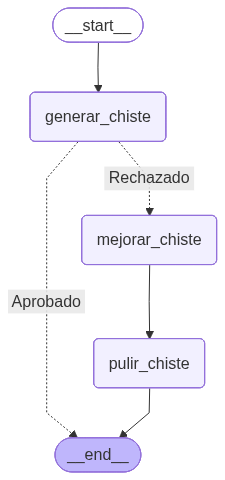

In [9]:
# Visualizar el flujo de trabajo
display(Image(cadena.get_graph().draw_mermaid_png()))

## ▶️ Probar el grafo

In [11]:
# Ejecutar la cadena
estado = cadena.invoke({"tema": "gatos"})

# Mostrar resultados
print("Chiste inicial:")
print(estado["chiste"])
print("\n--- --- ---\n")

if "chiste_mejorado" in estado:
    print("Chiste mejorado:")
    print(estado["chiste_mejorado"])
    print("\n--- --- ---\n")
    print("Chiste final:")
    print(estado["chiste_final"])
else:
    print("El chiste pasó el control de calidad - ¡se detectó remate!")

ChatGoogleGenerativeAIError: Error calling model 'models/gemini-2.5-flash-lite' (RESOURCE_EXHAUSTED): 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 20, model: gemini-2.5-flash-lite\nPlease retry in 1.337960086s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerDayPerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash-lite'}, 'quotaValue': '20'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '1s'}]}}